## Автоэнкодеры с условием (CAE)

### Мотивация

Как, используя обычный VAE, сгенерировать картинку с заданной меткой?

На самом деле, задача нетривиальна. Как вариант, мы можем понять, в какую область латентного пространства VAE отображает все 0, и затем сэмплировать уже из этой области.

Хорошо, а если мы хотим нарисовать единицу тем же почерком, которым нарисована данная нам тройка? В этом случае классический VAE вообще не получится использовать.

Есть еще одна проблема. Если распределение объектов действительно сильно зависит от какой-то дополнительной информации, например, того, какую цифру хотел изобразить человек, то KL-loss будет пытаться «скрестить ежа с ужом», и в результате мы получим очень странное представление, а на границах могут получаться несуществующие в реальности мутанты (если внимательно посмотрите на предыдущую картинку — так и получается).

### Несвязные компоненты и автокодировщик с условиями

Продемонстрировать мы это можем на модельной задаче. Сгенерируем два несвязных набора точек в двумерном пространстве, каждый из которых представляет собой некий паттерн с добавленным шумом.

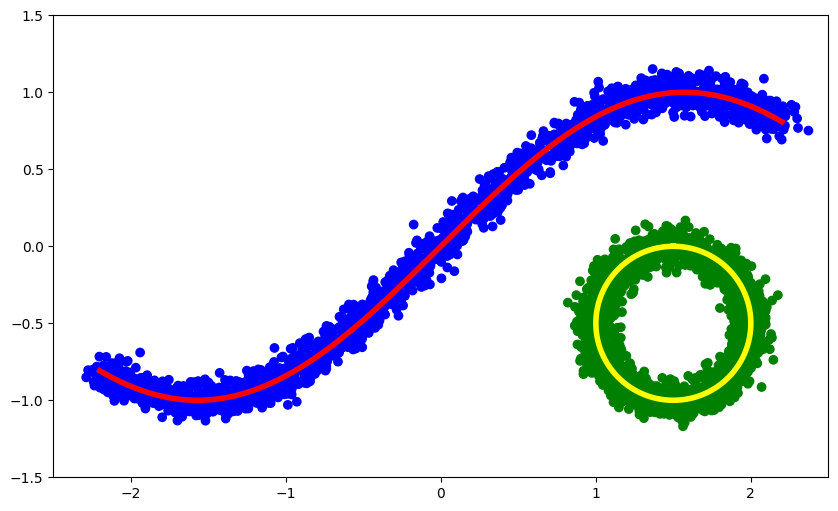

In [2]:
import numpy as np
import matplotlib.pyplot as plt


np.random.seed(42)

# create dataset
x1 = np.linspace(-2.2, 2.2, 2000)
fx = np.sin(x1)
dots1 = np.vstack([x1, fx]).T

t = np.linspace(0, 2 * np.pi, num=2000)
dots2 = 0.5 * np.array([np.sin(t), np.cos(t)]).T + np.array([1.5, -0.5])[None, :]

dots = np.vstack([dots1, dots2])
noise = 0.06 * np.random.randn(*dots.shape)

labels = np.array([0] * x1.shape[0] + [1] * t.shape[0])
noised = dots + noise


# Visualization
colors = ["b"] * x1.shape[0] + ["g"] * t.shape[0]
plt.figure(figsize=(10, 6))
plt.xlim([-2.5, 2.5])
plt.ylim([-1.5, 1.5])
plt.scatter(noised[:, 0], noised[:, 1], c=colors)
plt.plot(dots1[:, 0], dots1[:, 1], color="red", linewidth=4)
plt.plot(dots2[:, 0], dots2[:, 1], color="yellow", linewidth=4)
plt.grid(False)

Напишем простой автоэнкодер на полносвязных слоях:

In [3]:
from torch import nn

class SimpleEncoderDecoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(2, 32),
            nn.LeakyReLU(negative_slope=0.2),
            nn.Linear(32, 64),
            nn.LeakyReLU(negative_slope=0.2),
            nn.Linear(64, 1),
        )
        self.decoder = nn.Sequential(
            nn.Linear(1, 64),
            nn.LeakyReLU(negative_slope=0.2),
            nn.Linear(64, 32),
            nn.LeakyReLU(negative_slope=0.2),
            nn.Linear(32, 2),
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

В прошлых примерах мы этим пренебрегали, но автоэнкодер тоже может переобучаться. Поэтому сделаем разбиение на обучение и тест.

In [4]:
import torch
from sklearn.model_selection import train_test_split

x_train, x_test = train_test_split(noised, test_size=0.25, random_state=42)
x_train = torch.from_numpy(x_train).float()
x_test = torch.from_numpy(x_test).float()

Чтобы сильно не мучаться, поставим просто scheduler, который автоматически уменьшает learning rate нашей сети, если она переобучается или просто не улучшает качество на валидационном датасете.

In [5]:
from tqdm.notebook import tqdm

torch.manual_seed(42)

encdec = SimpleEncoderDecoder()
optimizer = torch.optim.Adam(encdec.parameters())
criterion = nn.MSELoss()
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, "min", patience=50
)  # to optimize learning rate


for epoch in tqdm(range(5000)):
    optimizer.zero_grad()
    x_restored = encdec(x_train)
    loss = criterion(x_train, x_restored)
    loss.backward()
    if optimizer.param_groups[0]["lr"] < 10e-7:  # if learning step becomes too small
        print(epoch)
        break

    with torch.no_grad():
        x_restored = encdec(x_test)
        val_loss = criterion(x_test, x_restored)
    scheduler.step(val_loss)
    optimizer.step()

  0%|          | 0/5000 [00:00<?, ?it/s]

In [6]:
print(val_loss)

tensor(0.0106)


In [7]:
with torch.no_grad():
    x_restored = encdec(x_test)
    dots_restored = x_restored.numpy()

Посмотрим, что выучил автоэнкодер. Видим, что он показывает связь там, где она явно отсутствует. Требование получить одно и то же представление для точек из двух паттернов мешает автоэнкодеру нормально выучить эти паттерны — они получаются смазанными или даже неверными.


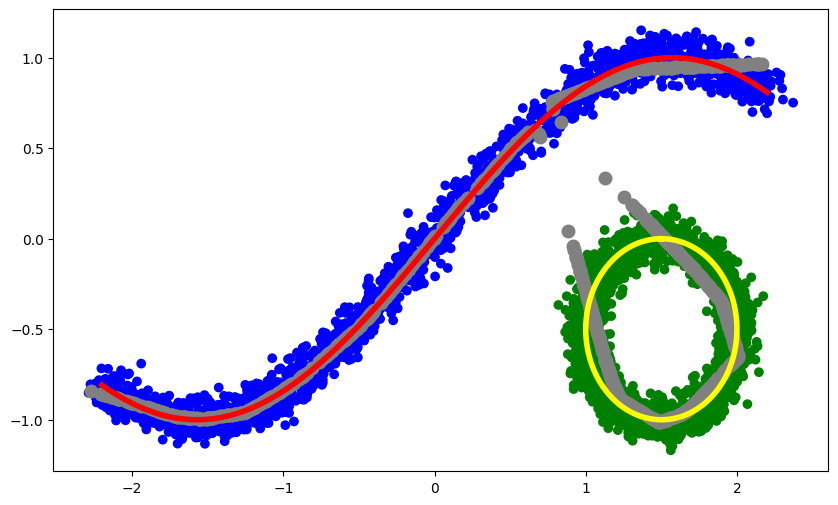

In [8]:
plt.figure(figsize=(10, 6))
plt.plot(dots1[:, 0], dots1[:, 1], color="red", linewidth=4)
plt.plot(dots2[:, 0], dots2[:, 1], color="yellow", linewidth=4)
plt.scatter(noised[:, 0], noised[:, 1], c=colors)
plt.scatter(dots_restored[:, 0], dots_restored[:, 1], color="grey", linewidth=4)
plt.grid(False)

Видим, что наш автоэнкодер восстанавливает часть объектов в область, где ничего нет. Потому что у него нет возможности понять, что это две несвязные компоненты.

А что будет, если мы будем передавать в кодировщик и в декодировщик метку объекта?
Тогда окажется, что наш автокодировщик работает в разы лучше:


In [9]:
class SimpleConditionalEncoderDecoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(3, 32),
            nn.LeakyReLU(negative_slope=0.2),
            nn.Linear(32, 64),
            nn.LeakyReLU(negative_slope=0.2),
            nn.Linear(64, 1),
        )
        self.decoder = nn.Sequential(
            nn.Linear(2, 64),
            nn.LeakyReLU(negative_slope=0.2),
            nn.Linear(64, 32),
            nn.LeakyReLU(negative_slope=0.2),
            nn.Linear(32, 2),
        )

    def forward(self, x, y):
        x = torch.cat(
            [x, y.view(-1, 1)], dim=1
        )  # combine the labels with X, change the dimension of the labels
        z = self.encoder(x)
        x = torch.cat([z, y.view(-1, 1)], dim=1)
        x = self.decoder(x)
        return x

In [10]:
x_train, x_test, y_train, y_test = train_test_split(
    noised, labels, test_size=0.25, random_state=42
)
x_train = torch.from_numpy(x_train).float()
y_train = torch.from_numpy(y_train).float()
x_test = torch.from_numpy(x_test).float()
y_test = torch.from_numpy(y_test).float()

In [23]:
torch.manual_seed(42)

encdec = SimpleConditionalEncoderDecoder()
optimizer = torch.optim.Adam(encdec.parameters())
criterion = nn.MSELoss()
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, "min", patience=50)


for epoch in tqdm(range(10000)):
    optimizer.zero_grad()
    x_restored = encdec(x_train, y_train)
    loss = criterion(x_train, x_restored)
    loss.backward()
    if optimizer.param_groups[0]["lr"] < 10e-7:
        print(epoch)
        break

    with torch.no_grad():
        x_restored = encdec(x_test, y_test)
        val_loss = criterion(x_test, x_restored)
    scheduler.step(val_loss)
    optimizer.step()

  0%|          | 0/10000 [00:00<?, ?it/s]

In [24]:
print(val_loss)

tensor(0.0041)


In [25]:
with torch.no_grad():
    X_restored = encdec(x_test, y_test)
    dots_restored = X_restored.numpy()

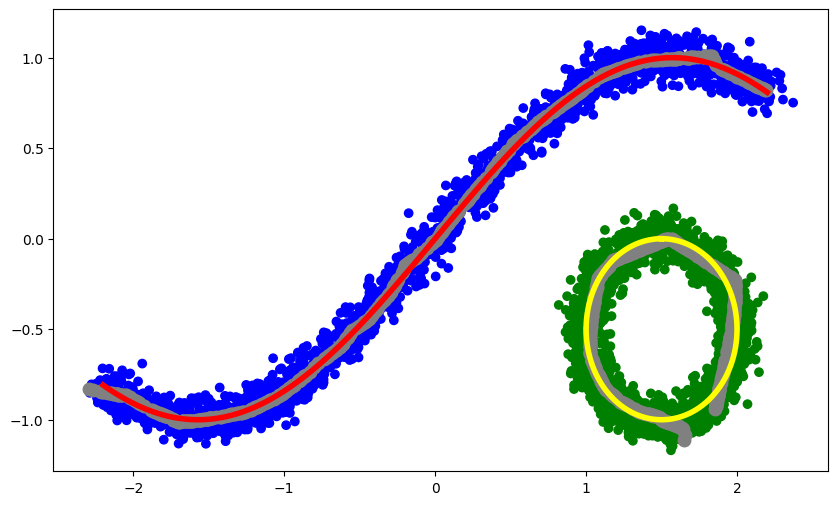

In [26]:
plt.figure(figsize=(10, 6))
plt.plot(dots1[:, 0], dots1[:, 1], color="red", linewidth=4)
plt.plot(dots2[:, 0], dots2[:, 1], color="yellow", linewidth=4)
plt.scatter(noised[:, 0], noised[:, 1], c=colors)
plt.scatter(dots_restored[:, 0], dots_restored[:, 1], color="grey", linewidth=4)
plt.grid(False)

Ситуация стала лучше. То, что мы применили, называется условными автоэнкодерами (Conditional AE). Конкретно — вместе с признаковым описанием объекта мы также передаем метки, которые указывают на то, что он относится к каким-то важным группам объектов, для которых, возможно, сети нужно учить отличное от других представление.